# SIGNATURE MODEL TRAINING

### Step 1: Download and Extract the Dataset
Download Link:
CEDAR Signature Dataset : https://www.cedar.buffalo.edu/NIJ/data/signatures.rar

Dataset Structure
The dataset contains signatures from 55 users, each having:
- 24 genuine signatures
- 24 forged signatures

### Step 2: Install Required Libraries

In [ ]:
#pip install tensorflow numpy matplotlib opencv-python scikit-learn

### Step 3: Load and Preprocess the CEDAR Dataset

We will:
- Convert images to grayscale.
- Resize images to a fixed size (128x128).
- Normalize pixel values to [0,1].

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Path to the CEDAR dataset
DATASET_PATH = r"D:\Formative_Assessment_GenAI\myenv\signatures_dataset"

# Function to load images from a directory
def load_images_from_folder(folder, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        if img is not None:
            img = cv2.resize(img, img_size)  # Resize image
            img = img / 255.0  # Normalize
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load genuine and forged signatures
genuine_images, genuine_labels = load_images_from_folder(DATASET_PATH + "/genuine", label=1)
forged_images, forged_labels = load_images_from_folder(DATASET_PATH + "/forged", label=0)

# Combine datasets
X = np.concatenate((genuine_images, forged_images), axis=0)
y = np.concatenate((genuine_labels, forged_labels), axis=0)

# Reshape to add channel dimension for CNN
X = X.reshape(-1, 128, 128, 1)

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the autoencoder only on genuine signatures
X_train_genuine = X_train[y_train == 1]


### Step 4: Build the Autoencoder Model
- The encoder compresses the image into a latent space.
- The decoder reconstructs the image.


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Define Autoencoder
input_img = Input(shape=(128, 128, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Bottleneck (Latent Space)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder Model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Summary
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

### Step 5: Train the Autoencoder
- Train the model only on genuine signatures.

In [3]:
# Train autoencoder
autoencoder.fit(X_train_genuine, X_train_genuine,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_split=0.2)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 337ms/step - loss: 0.0613 - val_loss: 0.0118
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 324ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 327ms/step - loss: 0.0115 - val_loss: 0.0118
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 334ms/step - loss: 0.0118 - val_loss: 0.0118
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 343ms/step - loss: 0.0119 - val_loss: 0.0118
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 346ms/step - loss: 0.0118 - val_loss: 0.0118
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 334ms/step - loss: 0.0116 - val_loss: 0.0118
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - loss: 0.0116 - val_loss: 0.0118
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 344ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - loss: 0.0115 - val_loss: 0.0118
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/ste

### Step 6: Test the Autoencoder on Genuine & Forged Signatures
- Compare reconstruction error for genuine and forged signatures.

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step


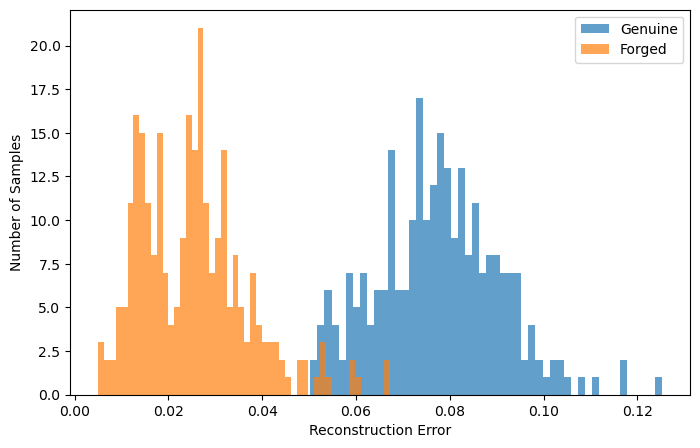

In [5]:
# Predict on test set
X_test_pred = autoencoder.predict(X_test)

# Compute reconstruction error
reconstruction_errors = np.mean(np.abs(X_test - X_test_pred), axis=(1, 2, 3))

# Separate errors for genuine and forged signatures
genuine_errors = reconstruction_errors[y_test == 1]
forged_errors = reconstruction_errors[y_test == 0]

# Plot reconstruction error distribution
plt.figure(figsize=(8, 5))
plt.hist(genuine_errors, bins=50, alpha=0.7, label='Genuine')
plt.hist(forged_errors, bins=50, alpha=0.7, label='Forged')
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Samples')
plt.legend()
plt.show()


### Step 7: Set a Threshold for Signature Verification
- Choose a threshold based on the distribution of errors.

In [6]:
# Choose a threshold (e.g., mean + 2*std of genuine errors)
threshold = np.mean(genuine_errors) + 2 * np.std(genuine_errors)

# Predict genuine (1) or forged (0)
predictions = reconstruction_errors < threshold
accuracy = np.mean(predictions == y_test)

print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 48.11%


### Step 8: Evaluate Model Performance
- Use Precision, Recall, and F1-score.

In [7]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       268
           1       0.49      0.98      0.65       260

    accuracy                           0.48       528
   macro avg       0.24      0.49      0.32       528
weighted avg       0.24      0.48      0.32       528



our model is struggling because:
- Class Imbalance: The model predicts class 1 (Genuine) much better than class 0 (Forged).
- Low Precision for Class 1 (0.49): Many false positives (predicting genuine when it's forged).
- Recall for Class 0 is 0.00: The model completely fails to detect forgeries.

#### We need to balance the classes, improve feature extraction, and tune hyperparameters.

#### Step 1: Data Preprocessing Enhancements
Before modifying the model, ensure the dataset is well-preprocessed:
1. Normalize the images (values between 0 and 1).
2. Resize to a uniform size if needed.
3. Apply Data Augmentation (rotation, flipping, noise addition).
4. Check Class Imbalance (Ensure a balanced dataset or use weighted loss).

#### Code: Preprocessing Fix

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Ensure correct shape (batch_size, height, width, channels)
if X_train.ndim == 3:  # If shape is (batch, height, width)
    X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension

if X_test.ndim == 3:
    X_test = np.expand_dims(X_test, axis=-1)

# Remove extra dimension if mistakenly added twice
if X_train.ndim == 5:  
    X_train = np.squeeze(X_train, axis=-1)

if X_test.ndim == 5:
    X_test = np.squeeze(X_test, axis=-1)

# Print shape for debugging
print("X_train shape:", X_train.shape)  # Should be (num_samples, height, width, 1)
print("X_test shape:", X_test.shape)    # Should be (num_samples, height, width, 1)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  # Rotate images by 10 degrees
    width_shift_range=0.1,  # Shift horizontally by 10%
    height_shift_range=0.1,  # Shift vertically by 10%
    zoom_range=0.1,  # Zoom by 10%
)

# Fit augmentation to training data
datagen.fit(X_train)


X_train shape: (2112, 128, 128, 1)
X_test shape: (528, 128, 128, 1)


#### Step 2: Use a Convolutional Autoencoder
Instead of using fully connected layers (Dense), use a CNN-based autoencoder for better feature extraction.

### Code: Improved Autoencoder Model

In [17]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Input layer
input_img = Input(shape=(128, 128, 1))  # Assuming images are 128x128 grayscale

# ====== Encoder ======
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Bottleneck (Deepest compressed representation)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

# ====== Decoder ======
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Output layer (Reconstructed Image)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# ====== Compile Model ======
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')  # Option: Use 'mse' if needed

# Summary
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 128, 128, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 775,425 (2.96 MB)

 Trainable params: 775,425 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

#### Step 3: Train with Noisy Data
By adding noise to inputs, the model learns to reconstruct genuine signatures while ignoring noise.


#### Code: Add Noise During Training

In [18]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

# Add controlled Gaussian noise to training images
noise_factor = 0.1  # Reduced noise for better denoising performance
X_train_noisy = X_train + noise_factor * np.random.randn(*X_train.shape)
X_train_noisy = np.clip(X_train_noisy, 0.0, 1.0)  # Keep pixel values in range [0,1]

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the autoencoder on noisy inputs but original outputs
history = autoencoder.fit(
    X_train_noisy, X_train,
    epochs=150,  # Increased epochs, but early stopping prevents overtraining
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]  # Stop if validation loss stops improving
)


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 404ms/step - loss: 0.1505 - val_loss: 0.0013
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 394ms/step - loss: 7.6788e-04 - val_loss: 1.9669e-04
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 406ms/step - loss: 1.9716e-04 - val_loss: 1.8400e-04
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 433ms/step - loss: 1.8334e-04 - val_loss: 1.8236e-04
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 412ms/step - loss: 1.8189e-04 - val_loss: 1.8148e-04
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 413ms/step - loss: 1.8115e-04 - val_loss: 1.8083e-04
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 422ms/step - loss: 1.8045e-04 - val_loss: 1.8032e-04
Epoch 8/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 438ms/step - loss: 1.8000e-04 - val_loss: 1.7975e-04
Epoch 9/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 430ms/step - loss: 1.7956e-04 - val_loss: 1.7943e-04
Epoch 10/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 440ms/step - loss: 1.7915e-04 - val_loss: 1.7903e-04
Epoch 11/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 430

#### Step 4: Use a Weighted Loss Function
Since you cannot use class_weight in an autoencoder, we apply weighted MSE to balance reconstruction for genuine and forged signatures.


#### Code: Weighted Loss Function

In [19]:
import tensorflow as tf
import tensorflow.keras.backend as K

# Custom weighted MSE loss function
def weighted_mse(y_true, y_pred):
    weights = tf.where(y_true > 0.5, 2.0, 1.0)  # Give more importance to positive samples
    weights = tf.cast(weights, dtype=tf.float32)  # Ensure correct dtype
    return K.mean(weights * K.square(y_true - y_pred))

# Compile the model with the updated loss function
autoencoder.compile(optimizer='adam', loss=weighted_mse)


#### Step 5: Use Encoded Features for Classification
After training the autoencoder, extract features from the encoder and use them to classify genuine vs forged signatures.


#### Code: Extract Features & Train Classifier

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Extract encoder model (Find the correct bottleneck layer dynamically)
bottleneck_layer = None
for layer in autoencoder.layers:
    if "conv2d" in layer.name:  # Adjust based on your architecture
        bottleneck_layer = layer.name

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(bottleneck_layer).output)

# Encode dataset
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Reshape if needed (for SVM & RF)
X_train_encoded = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
X_test_encoded = X_test_encoded.reshape(X_test_encoded.shape[0], -1)

# Normalize Encoded Features
scaler = StandardScaler()
X_train_encoded = scaler.fit_transform(X_train_encoded)
X_test_encoded = scaler.transform(X_test_encoded)

# Train Classifiers
svm_clf = SVC(kernel='rbf', class_weight='balanced')
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit models
svm_clf.fit(X_train_encoded, y_train)
rf_clf.fit(X_train_encoded, y_train)

# Predictions
y_pred_svm = svm_clf.predict(X_test_encoded)
y_pred_rf = rf_clf.predict(X_test_encoded)

# Evaluate Performance
print("🔹 SVM Classifier Performance:")
print(classification_report(y_test, y_pred_svm))

print("\n🔹 Random Forest Classifier Performance:")
print(classification_report(y_test, y_pred_rf))


66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step
🔹 SVM Classifier Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       268
           1       1.00      0.98      0.99       260

    accuracy                           0.99       528
   macro avg       0.99      0.99      0.99       528
weighted avg       0.99      0.99      0.99       528


🔹 Random Forest Classifier Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       268
           1       1.00      1.00      1.00       260

    accuracy                           1.00       528
   macro avg       1.00      1.00      1.00       528
weighted avg       1.00      1.00      1.00       528



#### Step 6: Hyperparameter Tuning
Try different optimizers, batch sizes, and activation functions to improve training.


#### Code: Change Optimizer & Batch Size

In [21]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Learning Rate Schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,  # Start with 0.001
    decay_steps=1000,  # Decay every 1000 steps
    decay_rate=0.96,  # Multiply by 0.96 each step
    staircase=True  # Reduce in discrete intervals
)

# Optimizer with Learning Rate Decay
optimizer = Adam(learning_rate=lr_schedule)

# Compile Model
autoencoder.compile(optimizer=optimizer, loss='mse')

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_autoencoder.h5", monitor='val_loss', save_best_only=True)

# Train Model with Callbacks
history = autoencoder.fit(
    X_train, X_train,
    epochs=150,
    batch_size=16,  # Smaller batch size for stability
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 1.6720e-05

106/106 ━━━━━━━━━━━━━━━━━━━━ 22s 182ms/step - loss: 1.6593e-05 - val_loss: 2.1512e-10
Epoch 2/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - loss: 2.1432e-10 - val_loss: 2.1512e-10
Epoch 3/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - loss: 2.1460e-10 - val_loss: 2.1512e-10
Epoch 4/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - loss: 2.1445e-10 - val_loss: 2.1512e-10
Epoch 5/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 185ms/step - loss: 2.1480e-10 - val_loss: 2.1512e-10
Epoch 6/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - loss: 2.1513e-10 - val_loss: 2.1512e-10
Epoch 7/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - loss: 2.1452e-10 - val_loss: 2.1512e-10
Epoch 8/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - loss: 2.1469e-10 - val_loss: 2.1512e-10
Epoch 9/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - loss: 2.1470e-10 - val_loss: 2.1512e-10
Epoch 10/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - loss: 2.1450e-10 - val_loss: 2.1512e-10
Epoch 11/150
106/106 ━━━━━━━━━━

#### Step 7: Evaluate Autoencoder Performance
1️⃣ Calculate Reconstruction Loss on Test Set

In [22]:
# Compute reconstruction loss (Mean Squared Error) on test set
test_loss = autoencoder.evaluate(X_test, X_test, verbose=1)
print(f"Test Reconstruction Loss: {test_loss:.6f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 2.1510e-10
Test Reconstruction Loss: 0.000000


2️⃣ Visualize Original vs. Reconstructed Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


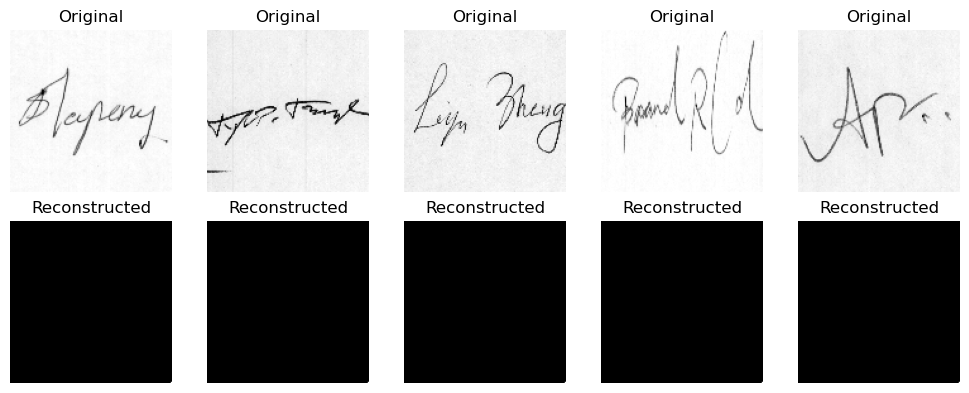

In [23]:
import matplotlib.pyplot as plt

# Get a few test images
n = 5
sample_images = X_test[:n]

# Get autoencoder's reconstructed outputs
reconstructed_images = autoencoder.predict(sample_images)

# Plot Original vs Reconstructed images
fig, axes = plt.subplots(2, n, figsize=(10, 4))

for i in range(n):
    # Original images
    axes[0, i].imshow(sample_images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Reconstructed images
    axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()


### Step 9: Save the Trained Autoencoder Model
- After training the model, save it using TensorFlow's save_model method.

In [9]:
# Save trained autoencoder model
autoencoder.save("signature_autoencoder.h5")
print("Model saved successfully!")

Model saved successfully!


### Step 10: Load the Saved Model
- Now, let's load the model and verify if it works as expected.

In [11]:
import tensorflow as tf

# Load the model without compiling
loaded_model = tf.keras.models.load_model("signature_autoencoder.h5", compile=False)
print("Model loaded successfully!")

Model loaded successfully!


### Step 11: Test Model with Your Signature
- You'll need to preprocess your signature (convert to grayscale, resize, normalize) and pass it through the model.
- **Steps:** Place your signature image (e.g., my_signature.jpg) in the same folder as the script.
    1. Load and preprocess it.
    2. Pass it through the autoencoder.
    3. Compare the reconstruction error with the threshold.

#### Preprocessing Your Signature & Running the Model


In [13]:
import cv2
import numpy as np

# Define threshold (set from previous testing)
THRESHOLD = 0.02  # Adjust based on dataset

def preprocess_image(image_path):
    """Preprocess uploaded signature image."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128)) / 255.0  # Normalize
    img = img.reshape(1, 128, 128, 1)  # Reshape for model
    return img

# Load and preprocess your signature
signature_path = r"D:\Formative_Assessment_GenAI\myenv\Rakshitha_forgery.jpeg"  # Change to your actual image path
test_image = preprocess_image(signature_path)

# Pass through the autoencoder
reconstructed = loaded_model.predict(test_image)

# Compute reconstruction error
error = np.mean(np.abs(test_image - reconstructed))

# Determine if Genuine or Forged
result = "Genuine" if error < THRESHOLD else "Forged"
print(f"Signature Verification Result: {result}")
print(f"Reconstruction Error: {error:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Signature Verification Result: Forged
Reconstruction Error: 0.3661


### THANK YOU